In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
import os
import json
from matplotlib import pyplot as plt
import mask
import functional as fn
import visualization as vis
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np


# Constants

In [2]:
RUN_TYPE = 'train'

DEVICE = 'cuda'

L1 = 0.0025
L2 = 0.01
H_2 = 0.0005

MU = 3e-3
RHO = 1050
V_MAX = 0.3
P_MAX = 90.
Q = (V_MAX / 2) * 2 * H_2


N = 257
N_POINTS = 1000

METHOD = 'PINN'
USE_WEIGHT_OPT = False
N_NEURONS = 32
N_LAYERS = 10
SCHEDULER_GAMMA = 0.99
SCHEDULER_PATIENCE = 140
BATCH_SIZE = 3
EPOCHS = 1000

N_INTERIOR = 500
N_WALLS = 250
N_INLET = 100
N_OUTLET = 100
N_BOUNDARY = N_WALLS + N_INLET + N_OUTLET

W_RES = 0.02
W_DIV = 0.02
W_V0 = 10000.
W_V_INLET = 1000.
W_P_OUTLET = 1.

if USE_WEIGHT_OPT:
    W_RES = torch.tensor(W_RES).to('cuda')
    W_RES.requires_grad_(True)
    W_DIV = torch.tensor(W_DIV).to('cuda')
    W_DIV.requires_grad_(True)
    W_V0 = torch.tensor(W_V0).to('cuda')
    W_V0.requires_grad_(True)
    W_V_INLET = torch.tensor(W_V_INLET).to('cuda')
    W_V_INLET.requires_grad_(True)
    W_P_OUTLET = torch.tensor(W_P_OUTLET).to('cuda')
    W_P_OUTLET.requires_grad_(True)

NORM_IN_SUB = torch.tensor([0.75, 4., 0, 0]).reshape(1, 1, 4).to(DEVICE)
NORM_IN_DIV = torch.tensor([0.33333, 1., 0.5 * L1, 0.5 * L2]).reshape(1, 1, 4).to(DEVICE)
NORM_OUT = torch.tensor([V_MAX, V_MAX, P_MAX]).reshape(1, 1, 3).to(DEVICE)

vis.set_params(12, L1, L2, 5)

# Dataset

In [3]:
def sampler(x, n):
    ind = torch.randperm(len(x))[:n]
    return x[ind]


class ClassDataset(Dataset):
    def __init__(self, path):
        self.interior = []
        self.walls = []
        self.inlet = []
        self.outlet = []
        self.center = []
        self.h = []

        files = os.listdir(path)
        self.masks = torch.zeros(len(files), 1, N, N).float()
        self.embeding = torch.zeros(len(files), 2).float()

        for idx in range(len(files)):
            file_path = os.path.join(path, files[idx])
            if '.stl' in file_path:
                mask_, x_interior, x_walls, x_inlet, x_outlet, center, h = mask.load_stl(file_path, N,
                                                                            N_POINTS * N_INTERIOR,
                                                                            N_POINTS * N_WALLS,
                                                                            N_POINTS * N_INLET,
                                                                            N_POINTS * N_OUTLET,
                                                                            length=[L1, L1, L2],
                                                                            device='cuda',
                                                                            use_3d=False,
                                                                            inside_buffer= 0.001)
                
                self.interior.append(x_interior)
                self.walls.append(x_walls)
                self.inlet.append(x_inlet)
                self.outlet.append(x_outlet)
                self.center.append(torch.tensor(center).to(DEVICE))
                self.h.append(torch.tensor(h).to(DEVICE))
                
                self.masks[idx] = mask_['num']
                self.embeding[idx, 0] = float(files[idx].split('_')[1].replace('-', '.'))
                self.embeding[idx, 1] = float(files[idx].split('_')[3][0])
            else:
                mask_, x_interior, x_walls, x_inlet, x_outlet, center, h = mask.img_to_mask(file_path, N,
                                                                            N_POINTS * N_INTERIOR,
                                                                            N_POINTS * N_WALLS,
                                                                            N_POINTS * N_INLET,
                                                                            N_POINTS * N_OUTLET,
                                                                            length=[L1, L1, L2],
                                                                            device='cuda',
                                                                            use_3d=False,
                                                                            inside_buffer= 0.001)
                
                self.interior.append(x_interior)
                self.walls.append(x_walls)
                self.inlet.append(x_inlet)
                self.outlet.append(x_outlet)
                self.center.append(torch.tensor(center).to(DEVICE))
                self.h.append(torch.tensor(h).to(DEVICE))
                
                self.masks[idx] = mask_['num']
                self.embeding[idx, 0] = float(files[idx].split('_')[1].replace('-', '.'))
                self.embeding[idx, 1] = float(files[idx].split('_')[3][0])

        self.sampler = sampler

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        x_interior = self.sampler(self.interior[idx], N_INTERIOR).to(DEVICE)

        emb_interior = self.embeding[idx].repeat(N_INTERIOR, 1).to(DEVICE)
        
        inputs_boundary = torch.cat((emb_interior[0].repeat(N_BOUNDARY, 1),
                                torch.cat((self.sampler(self.walls[idx], N_WALLS),
                                           self.sampler(self.inlet[idx], N_INLET),
                                           self.sampler(self.outlet[idx], N_OUTLET))).to(DEVICE)), 1)
        return emb_interior, x_interior, inputs_boundary, self.masks[idx], self.center[idx], self.h[idx]
        
def sample_boundarys(x):
    x_walls = x[:, :N_WALLS]
    x_inlet = x[:, N_WALLS:N_WALLS + N_INLET]
    x_outlet = x[:, N_WALLS + N_INLET:N_WALLS + N_INLET + N_OUTLET]

    return x_walls, x_inlet, x_outlet


def sample_v_inlet(inputs, center, h):
    with torch.no_grad():
        v_inlet_2 = (-((inputs[..., -2] - center) / - h) ** 2 + 1) * (2 * Q / (2 * h))
        v_inlet_1 = torch.zeros_like(v_inlet_2)
    return torch.stack((v_inlet_1, v_inlet_2), 2)


# ANN

In [4]:
def create_layers(input_size, hidden_layer_size, hidden_layers, output_size):
    layers = []
    for i in range(hidden_layers):
        if not i:
            layers += [nn.Linear(input_size, hidden_layer_size, bias=True),
                       nn.SiLU(inplace=True)]
            torch.nn.init.xavier_normal_(layers[-2].weight)
        else:
            layers += [nn.Linear(hidden_layer_size, hidden_layer_size, bias=True),
                       nn.SiLU(inplace=True)]
            torch.nn.init.xavier_normal_(layers[-2].weight)
            
    layers.append(nn.Linear(hidden_layer_size, output_size, bias=True))
    torch.nn.init.xavier_normal_(layers[-1].weight)
    
    return layers


class MLP(nn.Module):
    def __init__(self, hyp):
        super(MLP, self).__init__()
        input_size = 4
        output_size = 3 if METHOD == 'PINN' else 2
        self.mlp = []
        for i in range(output_size):
            layers = create_layers(input_size, hyp['hidden_layer_size'], hyp['hidden_layers'], 1)
            self.mlp.append(nn.Sequential(*layers))
        self.mlp1, self.mlp2, self.mlp3 = self.mlp
        self.output_size = output_size
    
    def forward(self, x):
        y = []
        for i in range(self.output_size):
            y.append(self.mlp[i]((x - NORM_IN_SUB) / NORM_IN_DIV) * NORM_OUT[..., i])
        return torch.cat(y, 2)

# Load train data

In [5]:
train_dataset = ClassDataset('dataset/train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Mask generation with path: dataset/train\h_0-2_d_6.stl
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/train\h_0-75_d_4.stl
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/train\h_0_d_0.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/train\h_1-5_d_4.stl
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done




# Training

In [6]:
if RUN_TYPE == 'train':
    best_loss = 1e10
    hyp = {'hidden_layer_size': N_NEURONS, 'hidden_layers': N_LAYERS}
    model = MLP(hyp).to(DEVICE)

    if USE_WEIGHT_OPT:
        optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-3, 'weight_decay': 0.},
                                    {'params': [W_RES, W_DIV, W_V0, W_V_INLET, W_P_OUTLET], 'lr': 1e-3, 'weight_decay': 0.}],
                                    lr=1e-3, weight_decay=0.)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)

    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=SCHEDULER_GAMMA)

    losses = {'res_losses': [],
              'div_losses': [],
              'v0_losses': [],
              'v_inlet_losses': [],
              'p_outlet_losses': [],
              'losses': [],
              'lr': []}

    for i in range(EPOCHS):
        n_iter = 0.

        losses['res_losses'].append(0.)
        losses['div_losses'].append(0.)
        losses['v0_losses'].append(0.)
        losses['v_inlet_losses'].append(0.)
        losses['p_outlet_losses'].append(0.)
        losses['losses'].append(0.)
        losses['lr'].append(0.)

        for emb_interior, x_interior, inputs_boundary, mask_, center, h in train_loader:
            optimizer.zero_grad()

            x_interior.requires_grad_(True)

            inputs_interior = torch.cat((emb_interior,
                                        x_interior), 2)
            
            outputs_interior = model(inputs_interior)

            outputs_walls, outputs_inlet, outputs_outlet = sample_boundarys(model(inputs_boundary))

            dv1, dv2, d2v1, d2v2, dp = fn.calc_grad(outputs_interior, x_interior)
            
            res_loss = fn.zero_loss(fn.calc_res(outputs_interior, dv1, dv2, d2v1, d2v2, dp, MU, RHO))
            div_loss = fn.mse_zero_loss(fn.calc_div(dv1, dv2))
            v0_loss = fn.mse_zero_loss(outputs_walls[..., :2])
            v_inlet_loss = torch.nn.functional.mse_loss(outputs_inlet[..., :2], sample_v_inlet(sample_boundarys(inputs_boundary)[1],
                                                                                               center.unsqueeze(1),
                                                                                               h.unsqueeze(1)))
            p_outlet_loss = fn.mse_zero_loss(outputs_outlet[..., 2])

            loss = W_RES * res_loss + W_DIV * div_loss + W_V0 * v0_loss + W_V_INLET * v_inlet_loss + W_P_OUTLET * p_outlet_loss
            loss.backward()

            losses['res_losses'][-1] += (res_loss.item())
            losses['div_losses'][-1] += (div_loss.item())
            losses['v0_losses'][-1] += (v0_loss.item())
            losses['v_inlet_losses'][-1] += (v_inlet_loss.item())
            losses['p_outlet_losses'][-1] += (p_outlet_loss.item())
            losses['losses'][-1] += (loss.item())
            losses['lr'][-1] += (lr_scheduler.get_lr()[0])
            n_iter += 1

            optimizer.step()

        losses['res_losses'][-1] /= n_iter
        losses['div_losses'][-1] /= n_iter
        losses['v0_losses'][-1] /= n_iter
        losses['v_inlet_losses'][-1] /= n_iter
        losses['p_outlet_losses'][-1] /= n_iter
        losses['losses'][-1] /= n_iter
        losses['lr'][-1] /= n_iter

        if losses['losses'][-1] < best_loss:
            best_loss = losses['losses'][-1]
            torch.save(model.state_dict(), f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth')
            torch.save(optimizer.state_dict(), f'work/{METHOD}_opt_{SCHEDULER_PATIENCE}.pth')
            

        if (not i % 1000) and i:
            print(f'Iteration {i + 1}')
            print('res_loss', losses['res_losses'][-1])
            print('div_loss', losses['div_losses'][-1])
            print('v0_loss', losses['v0_losses'][-1])
            print('v_inlet_loss', losses['v_inlet_losses'][-1])
            print('p_outlet_loss', losses['p_outlet_losses'][-1])
            print('loss', losses['p_outlet_losses'][-1])
            print('lr', losses['lr'][-1])
            with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'w') as fp:
                json.dump(losses, fp)
            
            
        if (not i % SCHEDULER_PATIENCE):
            lr_scheduler.step()

    optimizer.zero_grad()
        
    del x_interior, inputs_interior, emb_interior, inputs_boundary, mask_
    del outputs_interior, outputs_walls, outputs_inlet, outputs_outlet
    del dv1, dv2, d2v1, d2v2, dp
    del res_loss, div_loss, v0_loss, v_inlet_loss, p_outlet_loss, loss


c:\Users\chest\anaconda3\envs\Pytorch\lib\site-packages\torch\optim\lr_scheduler.py:622: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


# Save results

In [7]:
if RUN_TYPE == 'train':
    torch.save(model.state_dict(), f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth')
    torch.save(optimizer.state_dict(), f'work/{METHOD}_opt_{SCHEDULER_PATIENCE}.pth')
    with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'w') as fp:
        json.dump(losses, fp)


# Load saved model

In [6]:
hyp = {'hidden_layer_size': N_NEURONS, 'hidden_layers': N_LAYERS}

model = MLP(hyp).to(DEVICE)
model.load_state_dict(torch.load(f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth'))

with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'r') as fp:
    losses = json.load(fp)

# Plot training history

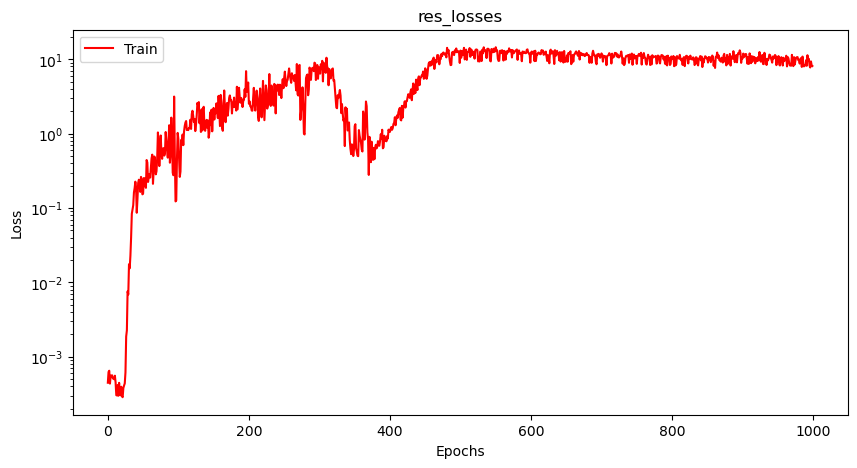

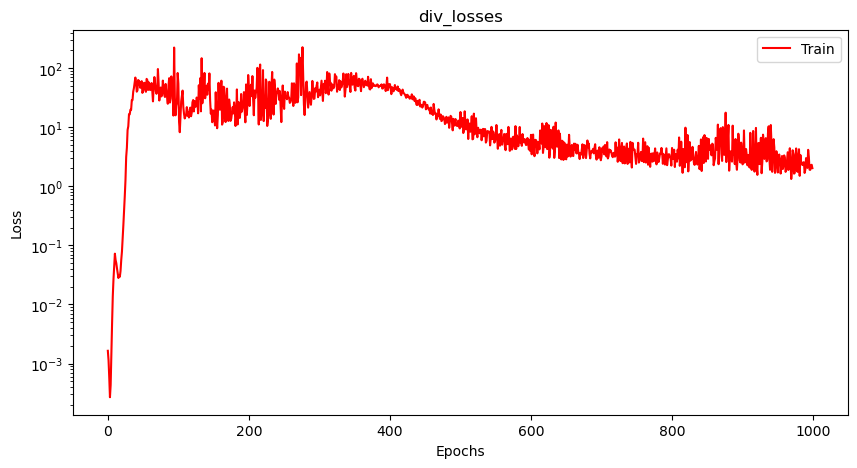

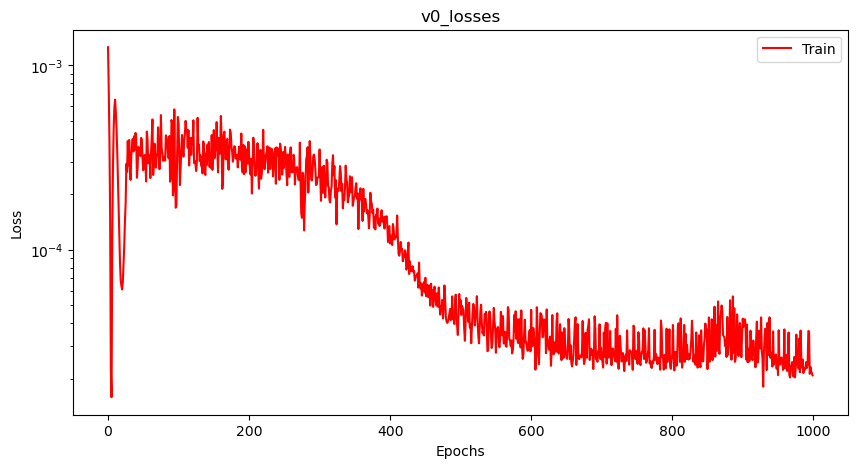

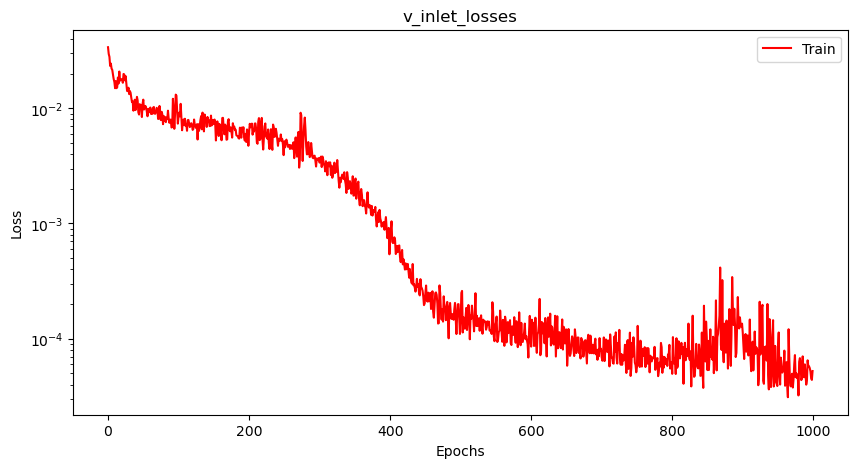

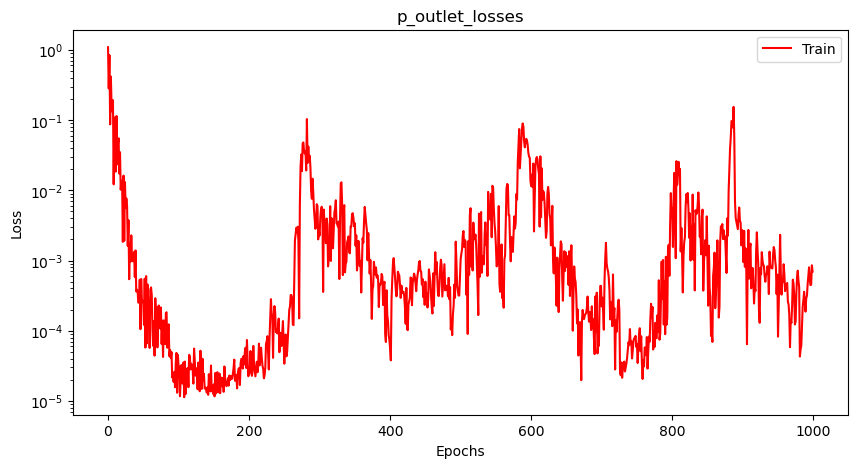

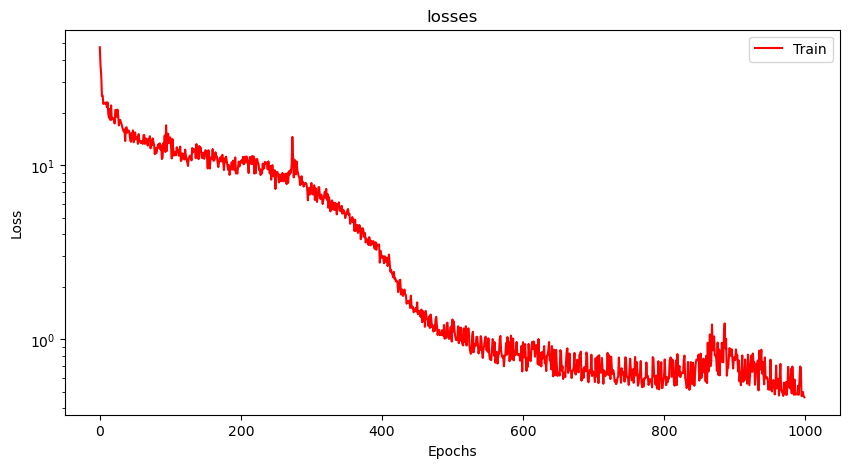

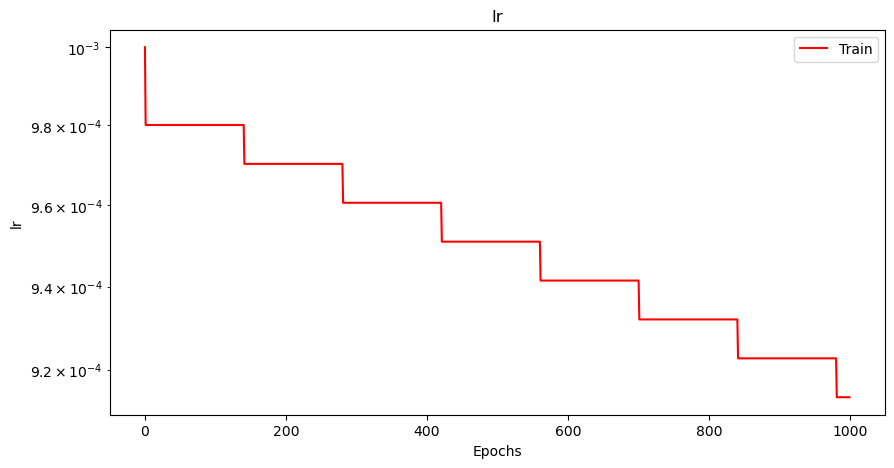

In [7]:
vis.train_history_plot(losses)

# Load test data

In [8]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

val_dataset = ClassDataset('dataset/val')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Mask generation with path: dataset/val\h_0-1_d_0.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/val\h_0_d_0-1.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done




# Visualize

In [9]:
def visualization(loader, title):
    print(f'{title} visualization')
    count = 0
    with torch.no_grad():
        for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
            x1 = torch.linspace(-L1 / 2, L1 / 2, N)
            x2 = torch.linspace(-L2 / 2, L2 / 2, N)
            x1, x2 = torch.meshgrid((x1, x2))
            x = torch.stack((x1.flatten(0), x2.flatten(0)), 1).to(DEVICE)

            inputs = torch.cat((emb_interior[0, 0].repeat(1, N * N, 1), x.to(DEVICE).unsqueeze(0)), 2)
            outputs = model(inputs)

            v1 = (outputs[..., 0].detach().cpu().reshape(N, N) * mask_[0])[0]
            v2 = (outputs[..., 1].detach().cpu().reshape(N, N) * mask_[0])[0]
            p = (outputs[..., 2].detach().cpu().reshape(N, N) * mask_[0])[0]

            print(f'h: {emb_interior[0][0][0].item()}, d: {emb_interior[0][0][1].item()}')

            vis.flow_visualization(v1, v2, x1, x2)
            vis.distribution_visualization(v1, 'v_1')
            vis.distribution_visualization(v2, 'v_2')
            vis.distribution_visualization(p, 'p')

            count += 1


## Visualize train dataset

Train visualization
h: 0.20000000298023224, d: 6.0


c:\Users\chest\anaconda3\envs\Pytorch\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


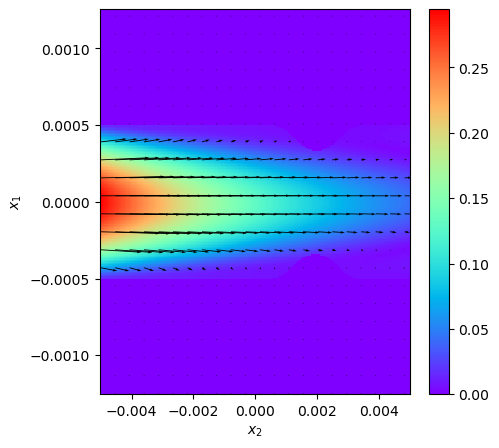

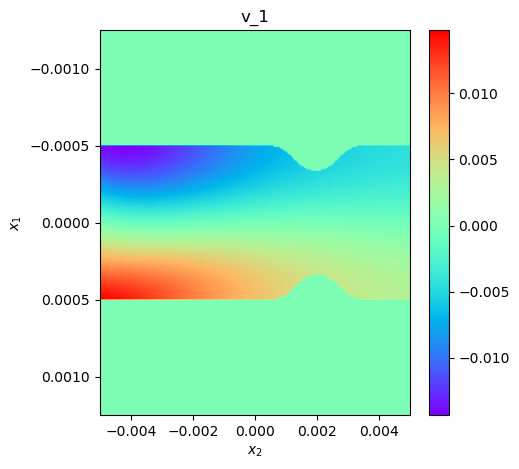

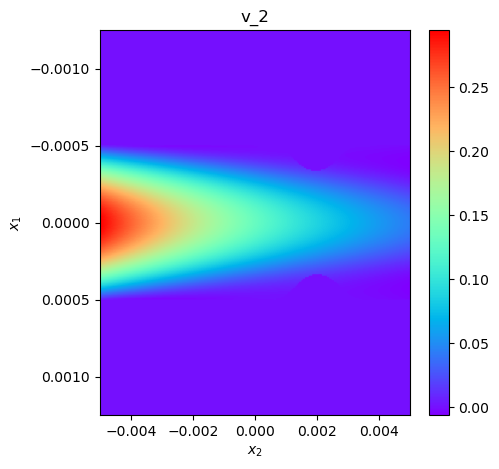

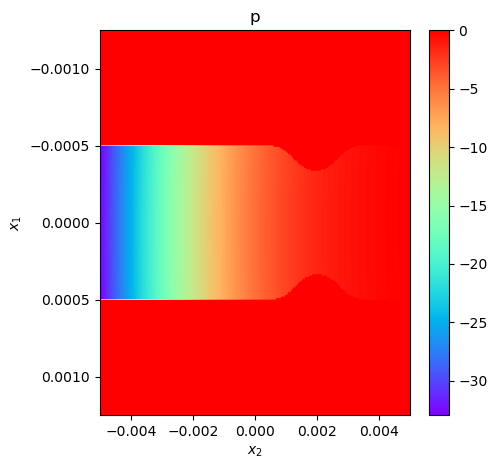

h: 0.75, d: 4.0


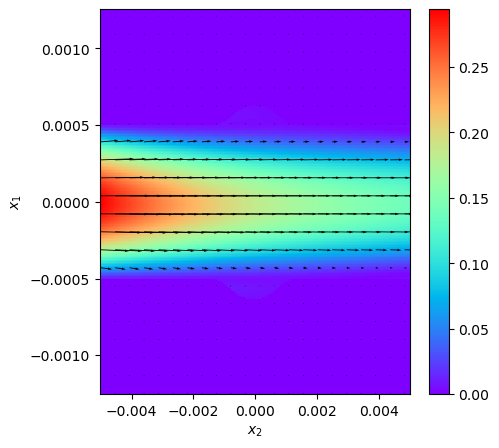

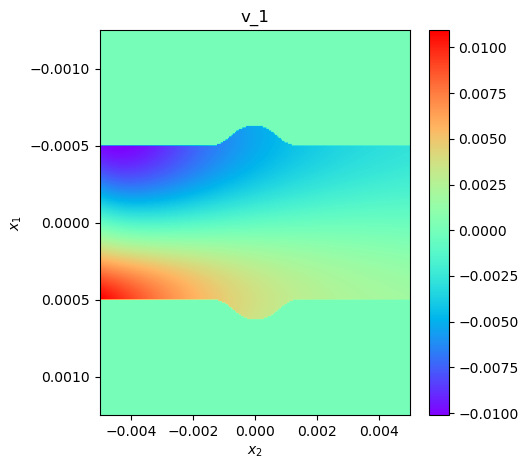

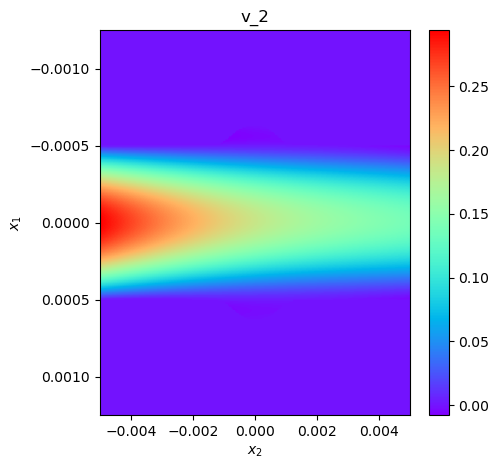

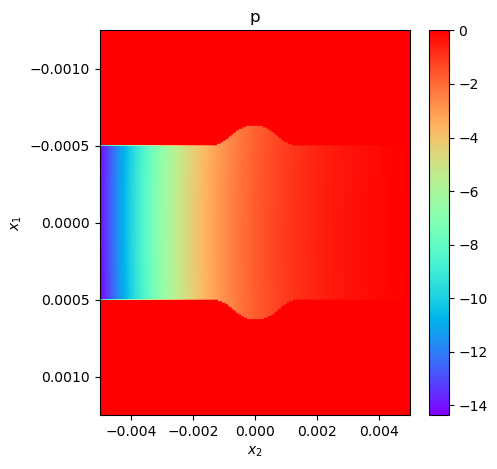

h: 0.0, d: 0.0


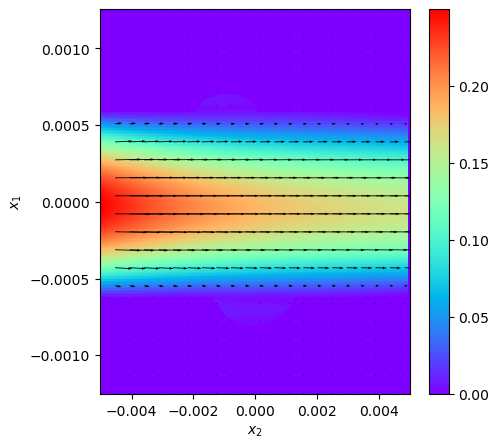

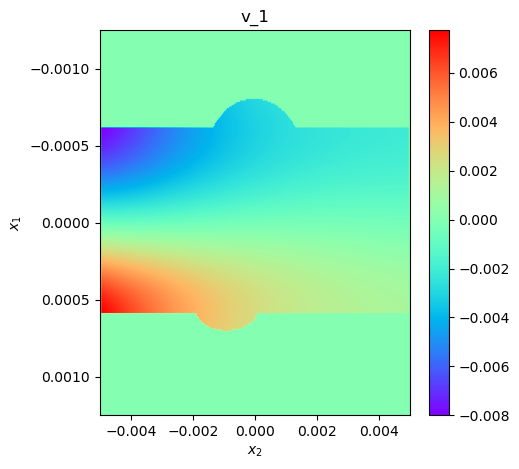

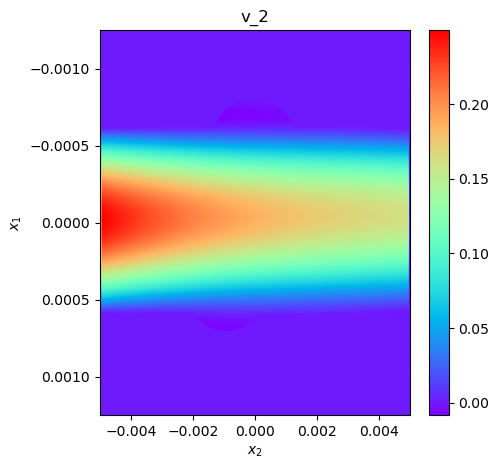

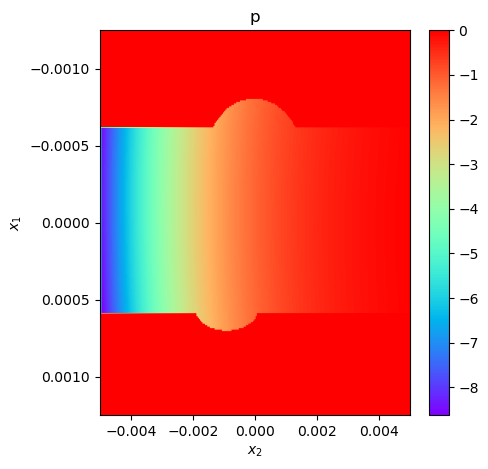

h: 1.5, d: 4.0


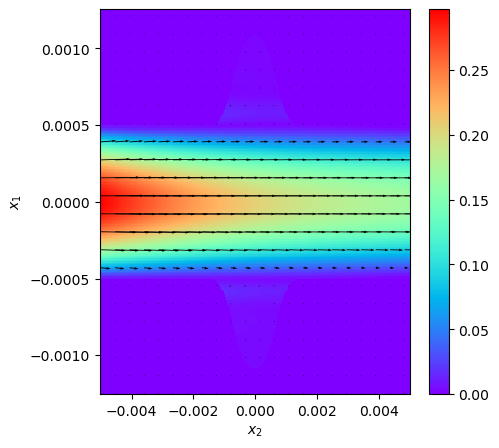

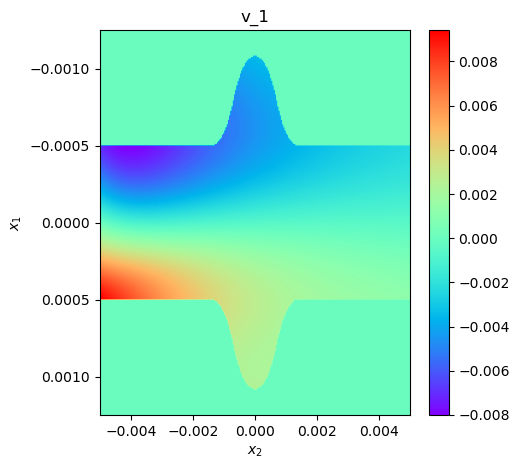

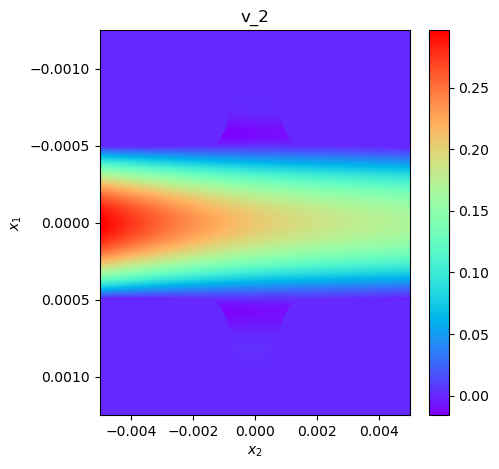

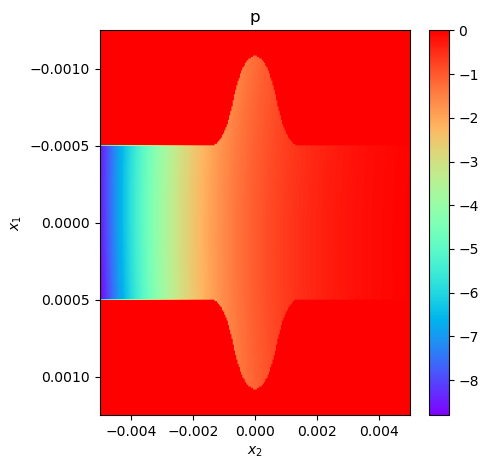

In [10]:
visualization(train_loader, 'Train')

## Visualize val dataset

Train visualization
h: 0.10000000149011612, d: 0.0


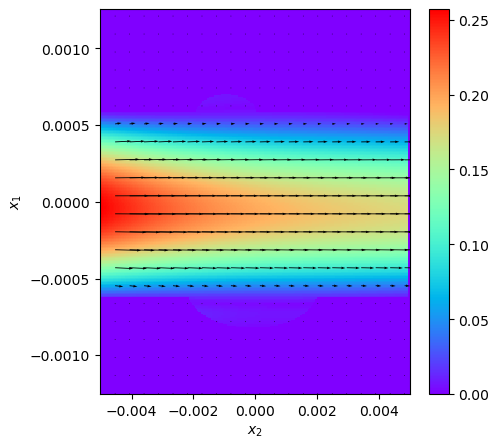

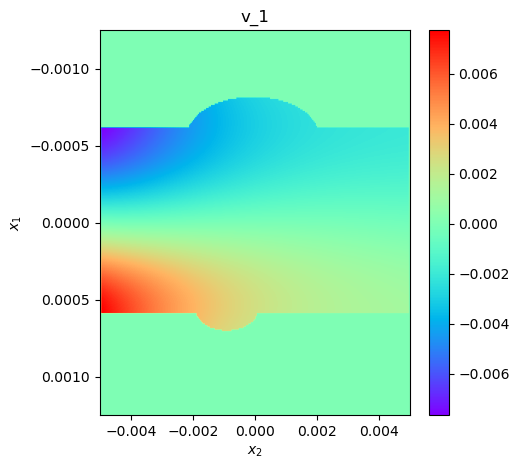

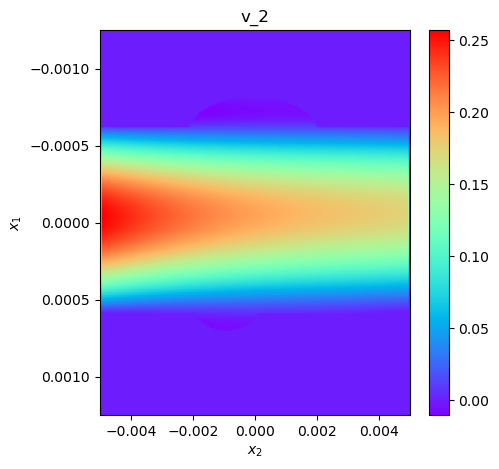

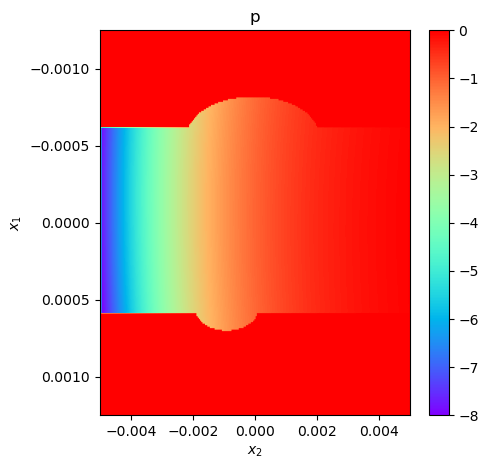

h: 0.0, d: 0.0


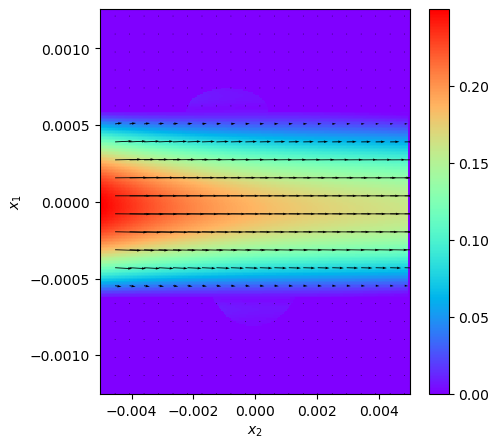

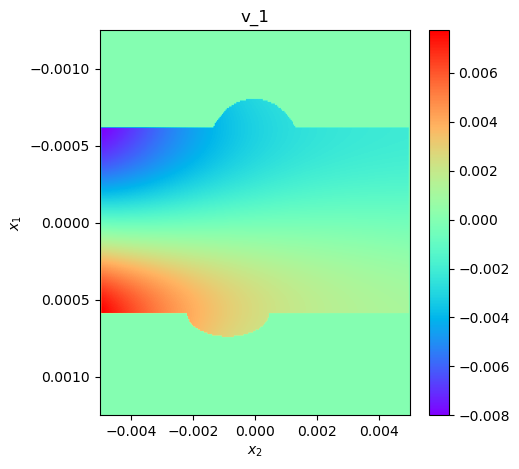

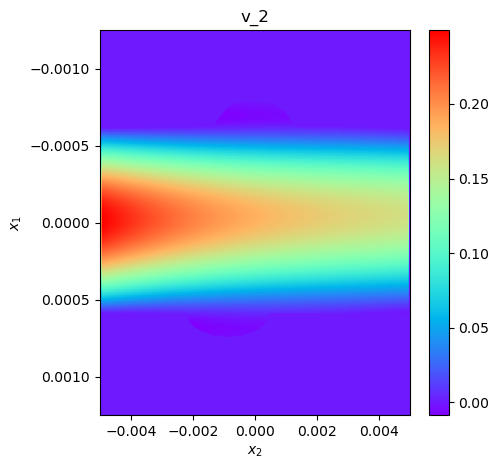

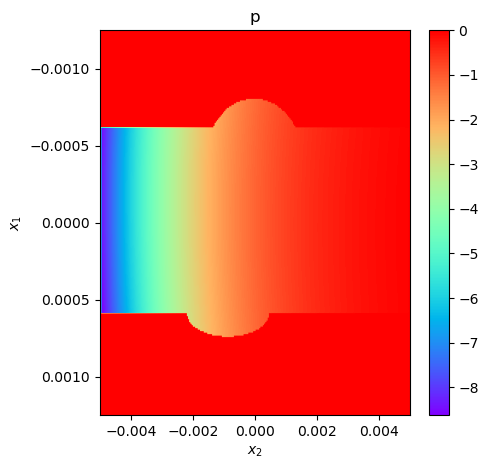

In [12]:
visualization(val_loader, 'Train')

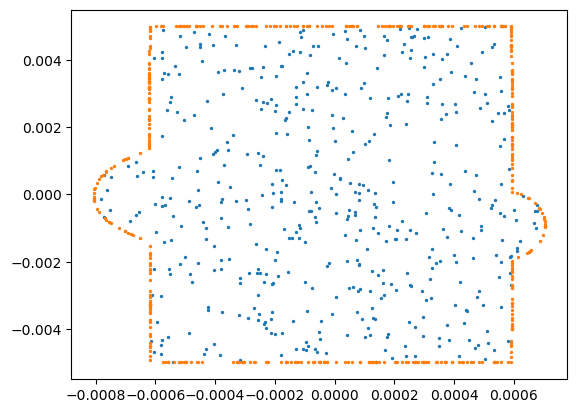

In [13]:
plt.scatter(*train_dataset[2][1].T.cpu(), s=2)
plt.scatter(*train_dataset[2][2][:, 2:].T.cpu(), s=2)